In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

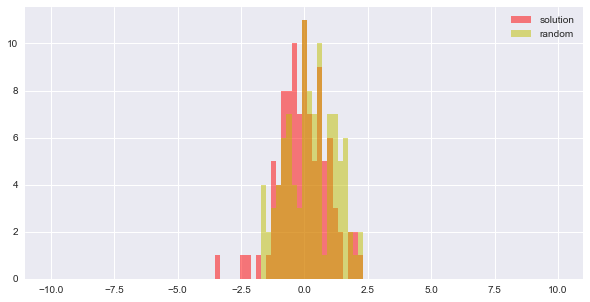

In [58]:
plt.figure(figsize = (10, 5))
bins = np.linspace(-10, 10, 100)

solution = np.random.randn(100)
w = np.random.randn(100)

plt.hist(solution, bins, alpha = 0.5, label = 'solution', color = 'r')
plt.hist(w, bins, alpha = 0.5, label = 'random', color = 'y')
plt.legend()
plt.show()

In [59]:
def f(w):
    return -np.sum(np.square(solution - w))


npop = 50
sigma = 0.1
alpha = 0.001

for i in range(5000):

    if (i + 1) % 1000 == 0:
        print(
            'iter %d. w: %s, solution: %s, reward: %f'
            % (i + 1, str(w[-1]), str(solution[-1]), f(w))
        )
    N = np.random.randn(npop, 100)
    R = np.zeros(npop)
    for j in range(npop):
        w_try = w + sigma * N[j]
        R[j] = f(w_try)

    A = (R - np.mean(R)) / np.std(R)
    w = w + alpha / (npop * sigma) * np.dot(N.T, A)

iter 1000. w: -0.1058426292462306, solution: -0.655674506360335, reward: -11.428269
iter 2000. w: -0.6458795215849504, solution: -0.655674506360335, reward: -0.006572
iter 3000. w: -0.6573843034846445, solution: -0.655674506360335, reward: -0.007692
iter 4000. w: -0.6532546235710635, solution: -0.655674506360335, reward: -0.007679
iter 5000. w: -0.6489526470097551, solution: -0.655674506360335, reward: -0.006191


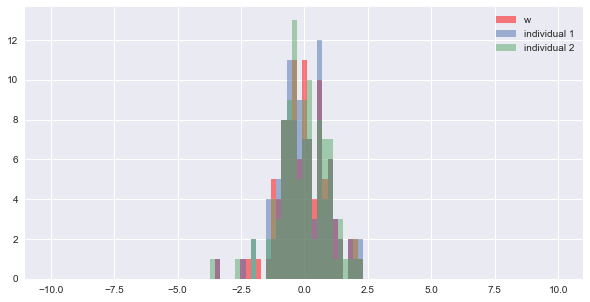

In [60]:
'''
I want to compare my first two individuals with my real w
'''
plt.figure(figsize=(10,5))

sigma = 0.1
N = np.random.randn(npop, 100)
individuals = []
for j in range(2):
    individuals.append(w + sigma * N[j])
    
    
plt.hist(w, bins, alpha=0.5, label='w',color='r')
plt.hist(individuals[0], bins, alpha=0.5, label='individual 1')
plt.hist(individuals[1], bins, alpha=0.5, label='individual 2')
plt.legend()
plt.show()

In [61]:
import pandas as pd
google = pd.read_csv('../dataset/GOOG.csv')
google.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-10-02,959.979980,962.539978,947.840027,953.270020,953.270020,1283400
1,2017-10-03,954.000000,958.000000,949.140015,957.789978,957.789978,888300
2,2017-10-04,957.000000,960.390015,950.690002,951.679993,951.679993,952400
3,2017-10-05,955.489990,970.909973,955.179993,969.960022,969.960022,1213800
4,2017-10-06,966.700012,979.460022,963.359985,978.890015,978.890015,1173900


In [62]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[: t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [63]:
close = google.Close.values.tolist()
get_state(close, 0, 10)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [64]:
get_state(close, 1, 10)

array([[0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 4.519958]])

In [65]:
get_state(close, 2, 10)

array([[ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  4.519958, -6.109985]])

In [66]:
class Deep_Evolution_Strategy:
    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T ###### Our task is to make this meta by storing each gradient into a global gradient from the MAML paper
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')

In [67]:
class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [68]:
window_size = 30
model = Model(window_size, 500, 3)

In [69]:
initial_money = 10000
starting_money = initial_money
len_close = len(close) - 1
weight = model
skip = 1

state = get_state(close, 0, window_size + 1)
inventory = []
quantity = 0

max_buy = 5
max_sell = 5


def act(model, sequence):
    decision, buy = model.predict(np.array(sequence))
    return np.argmax(decision[0]), int(buy[0])


for t in range(0, len_close, skip):
    action, buy = act(weight, state)
    next_state = get_state(close, t + 1, window_size + 1)
    if action == 1 and initial_money >= close[t]:
        if buy < 0:
            buy = 1
        if buy > max_buy:
            buy_units = max_buy
        else:
            buy_units = buy
        total_buy = buy_units * close[t]
        initial_money -= total_buy
        inventory.append(total_buy)
        quantity += buy_units
    elif action == 2 and len(inventory) > 0:
        if quantity > max_sell:
            sell_units = max_sell
        else:
            sell_units = quantity
        quantity -= sell_units
        total_sell = sell_units * close[t]
        initial_money += total_sell

    state = next_state
((initial_money - starting_money) / starting_money) * 100

2.93210027000001

In [70]:
import time


class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(
        self, model, money, max_buy, max_sell, close, window_size, skip
    ):
        self.window_size = window_size
        self.skip = skip
        self.close = close
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        len_close = len(self.close) - 1

        self.model.weights = weights
        state = get_state(self.close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, len_close, self.skip):
            action, buy = self.act(state)
            next_state = get_state(self.close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= self.close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * self.close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * self.close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        len_close = len(self.close) - 1
        state = get_state(self.close, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, len_close, self.skip):
            action, buy = self.act(state)
            next_state = get_state(self.close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= self.close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * self.close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * self.close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [73]:
model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(
    model = model,
    money = 10000,
    max_buy = 5,
    max_sell = 5,
    close = close,
    window_size = window_size,
    skip = 1,
)

In [74]:
agent.fit(iterations = 500, checkpoint = 10)

iter 10. reward: 4.500702
iter 20. reward: 4.034702
iter 30. reward: 5.951801
iter 40. reward: 7.500803
iter 50. reward: 7.231202
iter 60. reward: 7.500803
iter 70. reward: 7.500803
iter 80. reward: 7.500803
iter 90. reward: 7.500803
iter 100. reward: 5.081903
iter 110. reward: 7.701603
iter 120. reward: 7.701603
iter 130. reward: 7.701603
iter 140. reward: 7.701603
iter 150. reward: 7.701603
iter 160. reward: 7.701603
iter 170. reward: 7.701603
iter 180. reward: 7.701603
iter 190. reward: 7.701603
iter 200. reward: 7.701603
iter 210. reward: 7.701603
iter 220. reward: 7.701603
iter 230. reward: 7.701603
iter 240. reward: 7.701603
iter 250. reward: 7.701603
iter 260. reward: 7.701603
iter 270. reward: 7.701603
iter 280. reward: 7.701603
iter 290. reward: 7.701603
iter 300. reward: 7.701603
iter 310. reward: 7.701603
iter 320. reward: 7.701603
iter 330. reward: 7.701603
iter 340. reward: 7.701603
iter 350. reward: 7.701603
iter 360. reward: 7.701603
iter 370. reward: 7.701603
iter 380. 

day 0: buy 5 units at price 4766.350100, total balance 5233.649900
day 1: buy 5 units at price 4788.949890, total balance 444.700010
day 5, sell 5 units at price 4885.000000, investment 2.489324 %, total balance 5329.700010,
day 6: buy 5 units at price 4862.999880, total balance 466.700130
day 8, sell 5 units at price 4939.150085, investment 3.136391 %, total balance 5405.850215,
day 9: buy 1 units at price 989.679993, total balance 4416.170222
day 10: buy 5 units at price 4960.000000, total balance -543.829778
day 11, sell 5 units at price 4960.899965, investment 2.013162 %, total balance 4417.070187,
day 12, sell 5 units at price 4964.049990, investment 401.581322 %, total balance 9381.120177,
day 14: buy 5 units at price 4941.000060, total balance 4440.120117
day 16: buy 1 units at price 970.539978, total balance 3469.580139
day 18: buy 5 units at price 4862.799990, total balance -1393.219851
day 19, sell 5 units at price 5096.350100, investment 2.748994 %, total balance 3703.130249

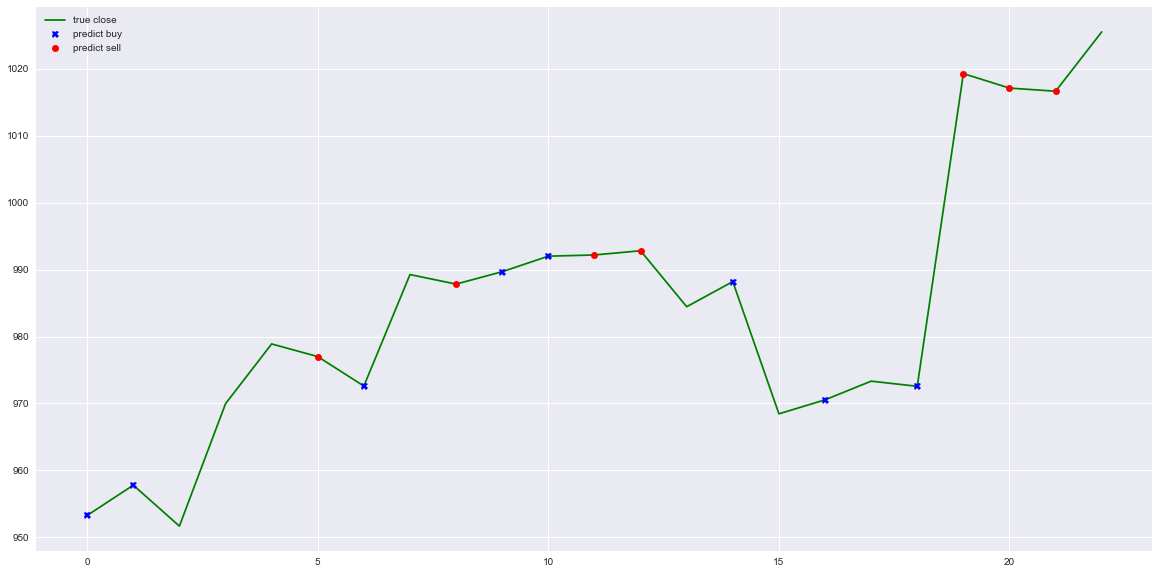

In [75]:
agent.buy()